In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

In [2]:
def cvt_local2global(local_point, sc_point):
    point = np.zeros((3, len(local_point)))
    x, y, a = local_point.T
    X, Y, A = sc_point
    point[0] = x * np.cos(A) - y * np.sin(A) + X
    point[1] = x * np.sin(A) + y * np.cos(A) + Y
    point[2] = a + A
    return point.T


def cvt_global2local(global_point, sc_point):
    point = np.zeros((3, len(global_point)))
    x, y, a = global_point.T
    X, Y, A = sc_point
    point[0] = x * np.cos(A) + y * np.sin(A) - X * np.cos(A) - Y * np.sin(A)
    point[1] = -x * np.sin(A) + y * np.cos(A) + X * np.sin(A) - Y * np.cos(A)
    point[2] = a - A
    return point.T

In [4]:
BEACONS = np.array([[-94, 50], [-94, 2000 - 50], [3000 + 90, 1000]])
R = 44

# Visualization scans

In [5]:
scan = np.load("scan.npy")

In [6]:
angles = np.linspace(0, 270, len(scan)) / 180 * np.pi - np.pi / 4
ranges = scan.T[0]
intens = scan.T[1]

In [7]:
max_range = 3000
min_inten = 2000
cond = (ranges < max_range) * (intens > min_inten)
x = (ranges * np.cos(angles))[cond]
y = (ranges * np.sin(angles))[cond]
inten = intens[cond]

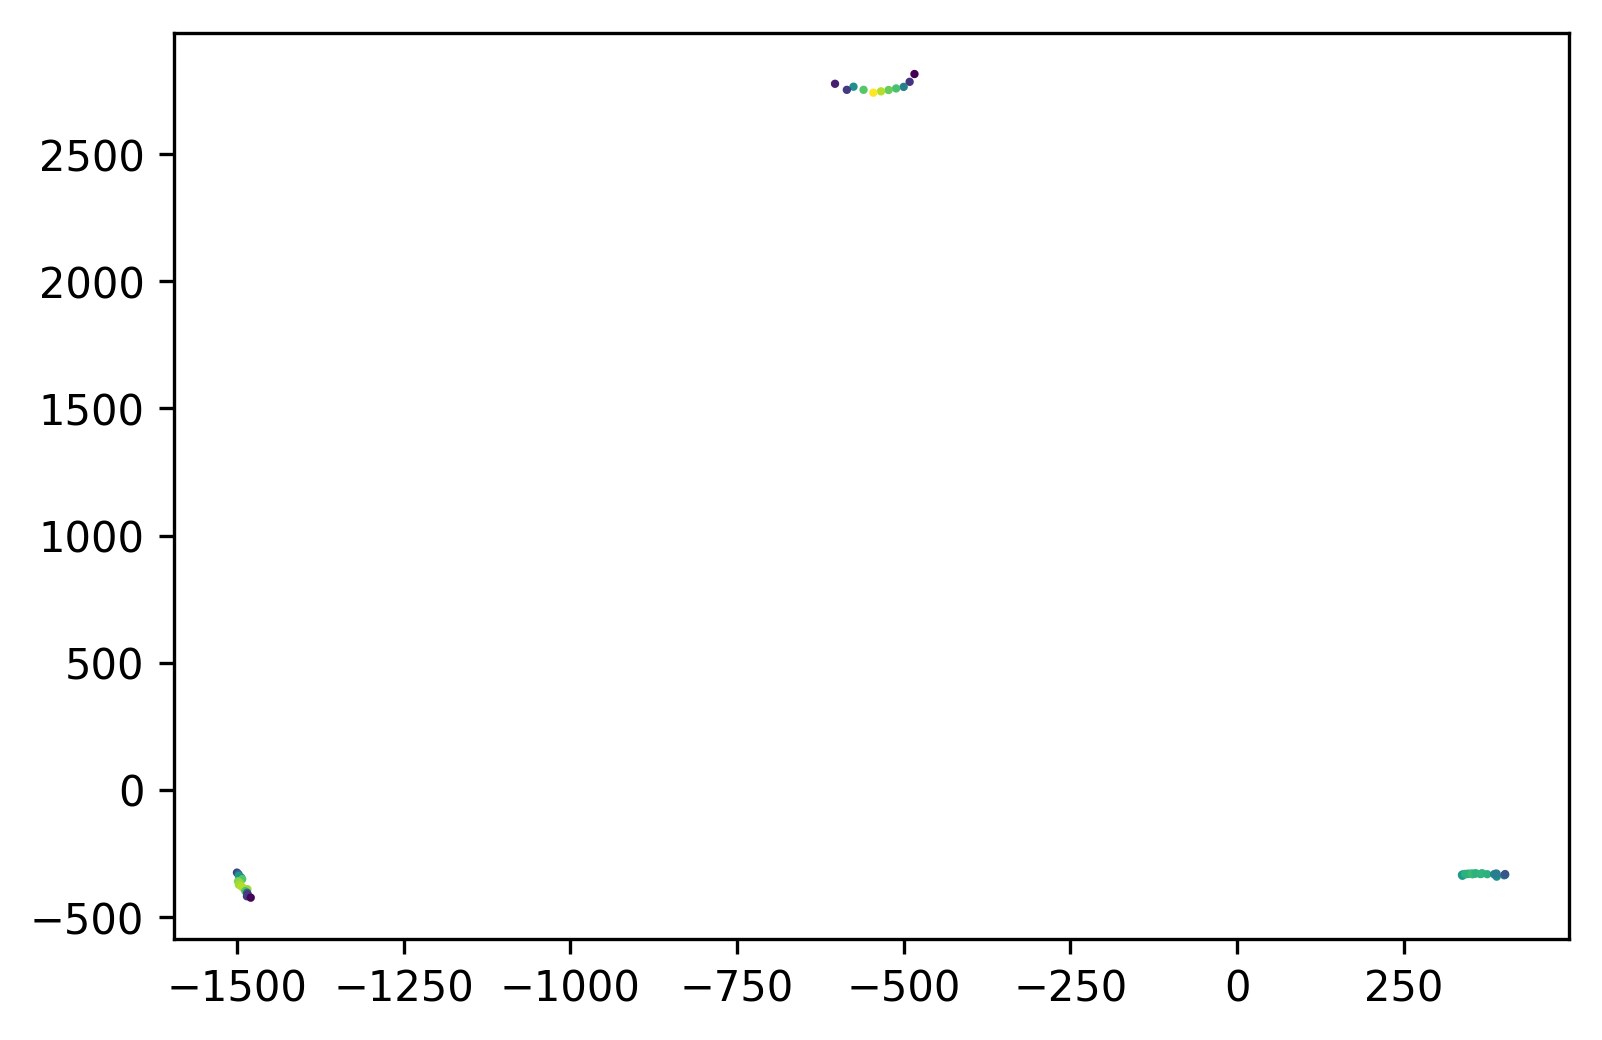

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
ax.scatter(x, y, s=1, c=inten)

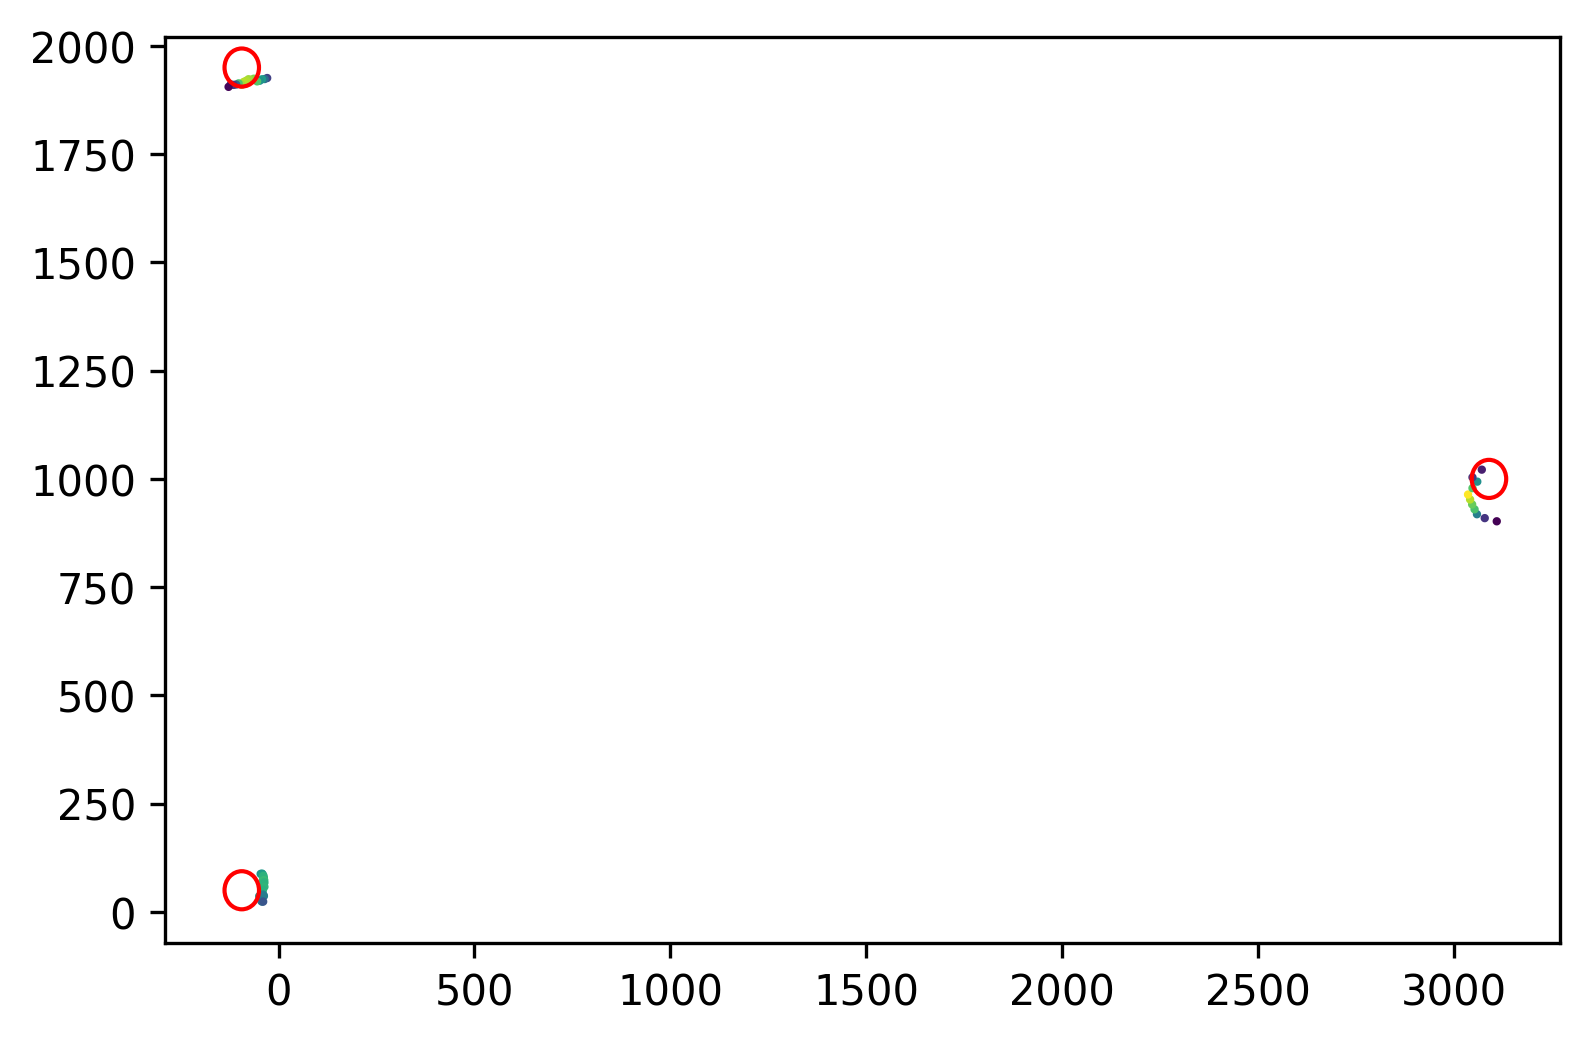

In [9]:
points = np.zeros((len(x), 3))
points[:, 0] = x
points[:, 1] = y

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
ax.scatter(*cvt_local2global(points, [293, 425, 4.71])[:, 0:2].T,  s=1, c=inten)
for b in BEACONS:
    ax.add_artist(plt.Circle(b, R, linewidth=1, fill=False, color="r"))

# Function

In [10]:
init_X = np.array([280, 400, 4.3])
init_X_true = np.array([293, 425, 4.71])
apr_points = cvt_local2global(points, init_X)[:, 0:2]
beacons_len = np.sum((BEACONS[np.newaxis, :, :] - apr_points[:, np.newaxis, :]
                     ) ** 2, axis=2) ** 0.5
num_beacons = np.argmin(beacons_len, axis=1)

In [11]:
def fun(X, points, num_beacons):
    beacons = BEACONS[num_beacons]
    points = cvt_local2global(points, X)[:, 0:2]
    r = np.sum((beacons - points) ** 2, axis=1) ** 0.5 - R
    return r

# Minimization

In [12]:
%%time
res = scipy.optimize.least_squares(fun, init_X, loss="linear",
                                   args=[points, num_beacons], ftol=1e-3)

CPU times: user 11.3 ms, sys: 1.2 ms, total: 12.5 ms
Wall time: 17.1 ms


In [13]:
res.x

array([284.48325398, 427.5170985 ,   4.71892758])

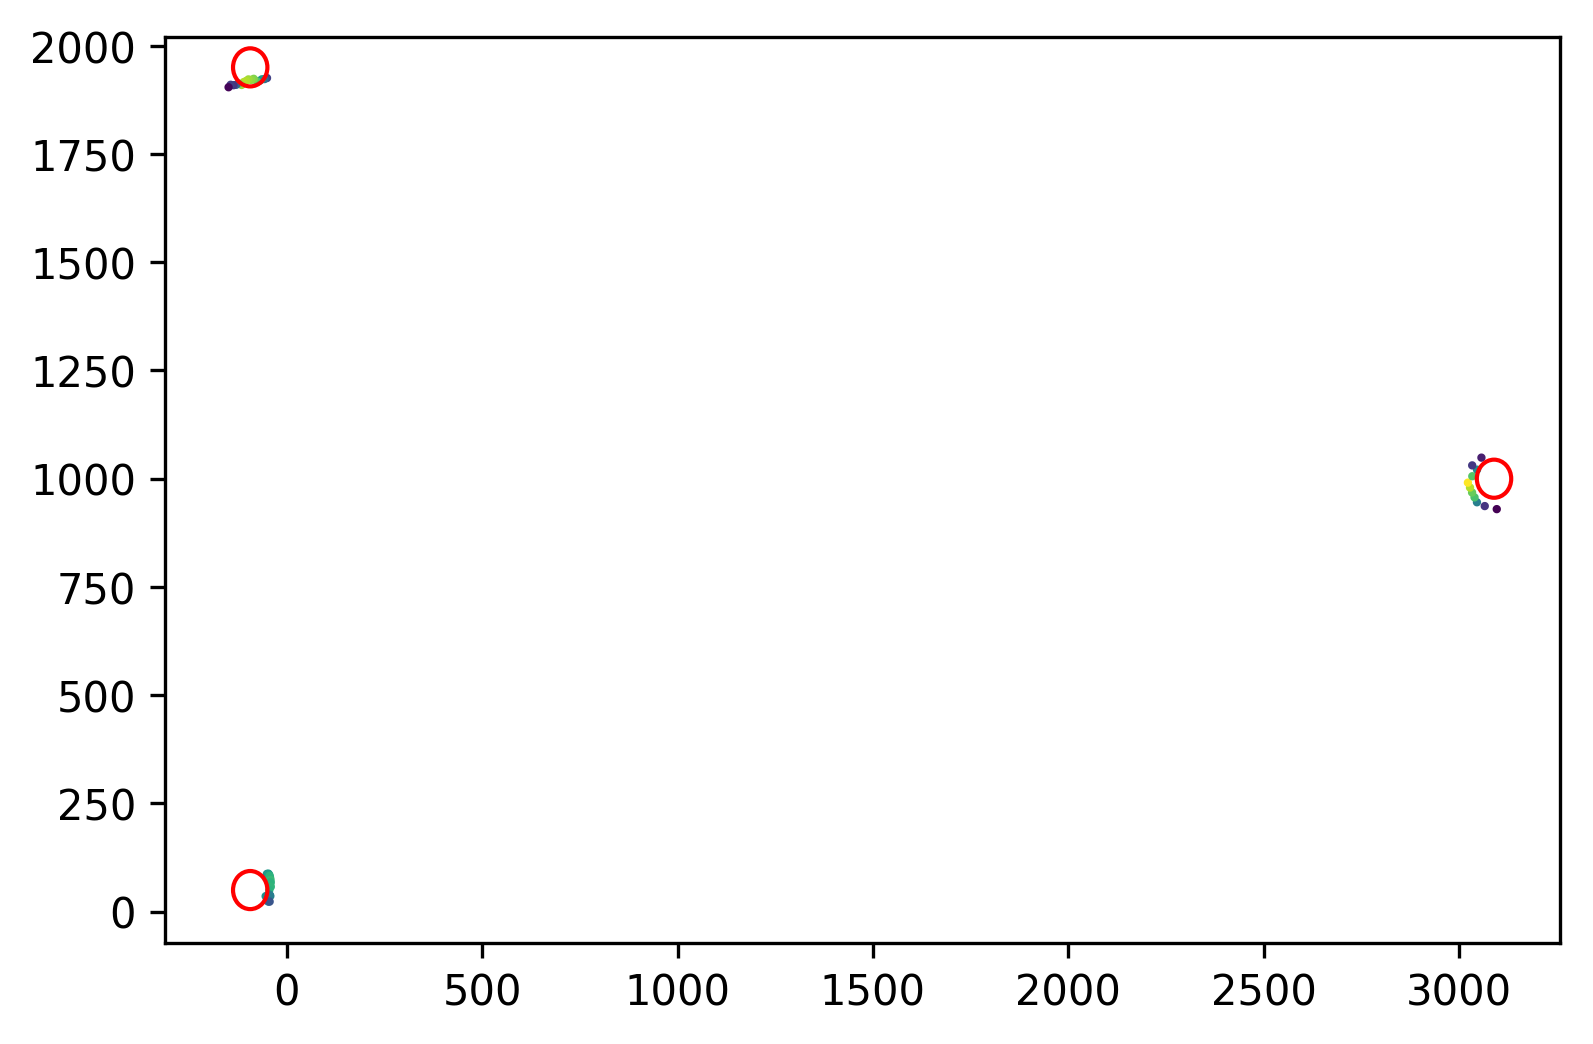

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
ax.scatter(*cvt_local2global(points, res["x"])[:, 0:2].T,  s=1, c=inten)
for b in BEACONS:
    ax.add_artist(plt.Circle(b, R, linewidth=1, fill=False, color="r"))